# Chapter 8 - Gradient Descent

This chapter deals with solving optimization problems from scratch through gradient descent.
There's lots of helpful illustrations in this chapter so I recommend reading it. 

In [18]:
# we'll need some functions from previous chapters
import math

def vector_subtract(v, w): 
    return [v_i - w_i
           for v_i, w_i in zip(v,w)]

def magnitude(v):
    return math.sqrt(sum_of_squares(v))

def squared_dist(v,w):
    return sum_of_squares(vector_subtract(v,w))

def distance(v,w):
    return magnitude(vector_subtract(v,w))

In [15]:
# create some function f that takes in a vector of real numbers and outputs a single real number

def sum_of_squares(v):
    return sum(v_i ** 2 for v_i in v)

# we'll need to often maximize or minimize such functions
# the gradient is the vector of partial derivatives, df/dx, and gives the input direction in which the function most quickly increases
# Take a small step in the direction of the gradient and re-calculate

#beware of local minima, or local-maxima.com (MY PODCAST!)

# we want ot measure how f(x) changes when we make a small change in x

def difference_quotient(f,x,h):
    return (f(x+h) - f(x)) / h

# as h approaches zero, or the limit of the difference quotient


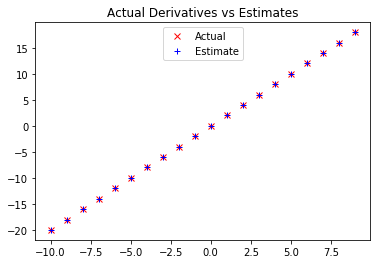

In [16]:
# we can take the actual derivative of a lot of functions and simultaneously remember the best part of high school

def square(x):
    return x*x

def derivative(x):
    return 2 * x

# but what if we can't explicitly find the gradient? We can find the difference quotient given very small e.
from functools import partial 

derivative_estimate = partial(difference_quotient, square, h=0.00001)

# let's plot it to see 
import matplotlib.pyplot as plt
x = list(range(-10, 10))
y_1 = list(map(derivative, x)) # work around for matplotlib not taking generators as inputs. 
y_2 = list(map(derivative_estimate, x))

plt.title("Actual Derivatives vs Estimates")
plt.plot(x, y_1, 'rx', label='Actual')

plt.plot(x, y_2, "b+", label='Estimate')
plt.legend(loc=9)
plt.show()

In [23]:
# we'll need partial derivatives, the derivative with respect to one variable holding the others constant

def partial_difference_quotient(f, v, i, h,):
    w = [v_j + (h if j == i else 0)]
    
    return (f(w) - f(v)) / h

def estimate_gradient(f, v, h=0.00001):
    return [partial_difference_quotient(f, v, i, h)
           for i, _ in enumerate(v)]

# this is computationally expensive. if v has length n, estimate_gradient() has to evaluate f on 2n inputs. beware...

# Let's get to the minimum of sum of squares through gradient descent
def step(v, direction, step_size):
    return [v_i + step_size * direction_i for v_i, direction_i in zip(v, direction)]

def sum_of_squares_gradient(v):
    return [2 * v_i for v_i in v]

# pick a random starting point
import random
v = [random.randint(-10, 10) for i in range(3)]

tolerance = 0.0000001

while True:
    gradient = sum_of_squares_gradient(v)
    next_v = step(v, gradient, -0.01)
    if distance(next_v, v) < tolerance:
        break
    v = next_v
print(v)
    
    

[1.0444801517282768e-06, 3.65568053104897e-06, -3.1334404551848313e-06]


In [25]:
# the smaller you make the tolerance, the closer you get to the actual answer which is obviously 0,0,0

# choosing step size is as much art as science. We can try a bunch to estimate which is best
step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]

# we can make a safety function that makes sure certain inputs that break our function don't get through
def safe(f):
    def safe_f(*args, **kwargs):
        try:
            return f(*args, **kwagrs)
        except:
            float('inf')
            
    return safe_f


## Let's put it all together
We have same target function and it's gradient. We could be minimizing errors in a model as a function of its parameters. We choose a starting value (however we do that) and implement gradient descent:

In [27]:
def minimize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
    theta = theta_0
    target_fn = safe(target_fn)
    value = target_fn(theta)
    
    while True:
        gradient = gradient_fn(theta)
        next_thetas = [step(theta, gradient, -step_size) for step_size in step_sizes]
        next_theta = min(next_thetas, key=target_fn) # choosing the one that minimizes the error function
        next_value = target_fn(next_theta)
        
        # stop if converging
        if abs(value - next_value) < tolerance:
            return theta
        else:
            theta, vaue = next_theta, next_value
# in this case we take in all the data. we'll see later how to look at a point at a time

In [28]:
# sometimes we want to maximize, or minimize the negative of a function

def negate(f):
    return lambda *args, **kwargs: -f(*args, **kwargs)

def negate_all(f):
    return lambda *args, **kwargs: [-y for y in -f(*args, **kwargs)]

def maximize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    return minimize_batch(negate(target_fn), negate_all(gradient_fn), theta_0, tolerance)

# we'll use this stuff throughout the rest of the book


## Stochastic Gradient Descent
I've only ever used it in machine learning, it's nice to see it from scratch. 

The reason the batch method is slow is that we have to make a prediction and compute the gradient for the whole data set at each step. Usually the error functions are additive, which means the predictive error on the whole data set is simply the sum of the predictive errors for each data point. When this is the case, we can compute the gradient and take a step for only one point at a time. 

In [30]:
# in each cycle we want to iterate through our data in a random order

def in_random_order(data):
    indices = [i for i, _ in enumerate(data)]
    random.shuffle(indices) #Joel writes indexes but that's not the pluralization.
    for i in indices:
        yield data[i]
        
# and then we take a gradient step and quit when we stop getting improvements

def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    
    data = zip(x,y,)
    theta = theta_0
    alpha = alpha_0
    
    min_theta, min_value = None, float('inf')
    iterations_with_no_improvement = 0
    
    # we want to stop when we don't see any improvement try shrinking the step size, but if we do keep going
    while iterations_with_no_improvement < 100:
        value = sum( target_fn(x_i, y_i, theta) for x_i, y_i in data )
        
        if value < min_value:
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:
            iterations_with_no_improvement += 1
            alpha *= 0.9
            
        # take a gradient step
        for x_i, y_i in in_random_order(data):
            gradient_i = gradient_fn(x_i, y_i, that)
            theta = vector_subtract(theta, scalar_multiply(alpha, gradient_i))
            
    return min_theta
# this will be faster than the batch version

# we want a maximizer as well
def maximize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    return minimize_stochastic(negate(target_fn), negate_all(gradient_fn), x, y, theta_0, alpha_0) # quite the one-liner



## This concludes Chapter 8.

We'll be using these functions a lot in the rest of the book. For a calculus refresher there's Active Calculus, which does sound nice than Thomas' Calculus. Thomas' calculus is all of undergraduate calculus in one place, and actually a pretty good textbook, but it looks nicer on the shelf than it does for refreshing reading.

Scikit learn and tensorflow both have stochastic gradient descent functions that might be nicer that ours (and obviously keras does everything for you) but